In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import pandas as pd 
import numpy as np
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
import os

def preprocess_image(image, label, image_shape=224):
  image= tf.image.resize(image,[image_shape, image_shape])
  return tf.cast(image, tf.float32), label

In [2]:
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split = ["train", "validation"],
                                             shuffle_files = True,
                                             as_supervised = True,
                                             with_info = True)

In [3]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_path='C:\\Users\\Essam\\tensorflow_datasets\\food101\\2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train'

In [4]:
print(f"Training dataset size: {tf.data.experimental.cardinality(train_data).numpy()}")
print(f"Test dataset size: {tf.data.experimental.cardinality(test_data).numpy()}")

Training dataset size: 75750
Test dataset size: 25250


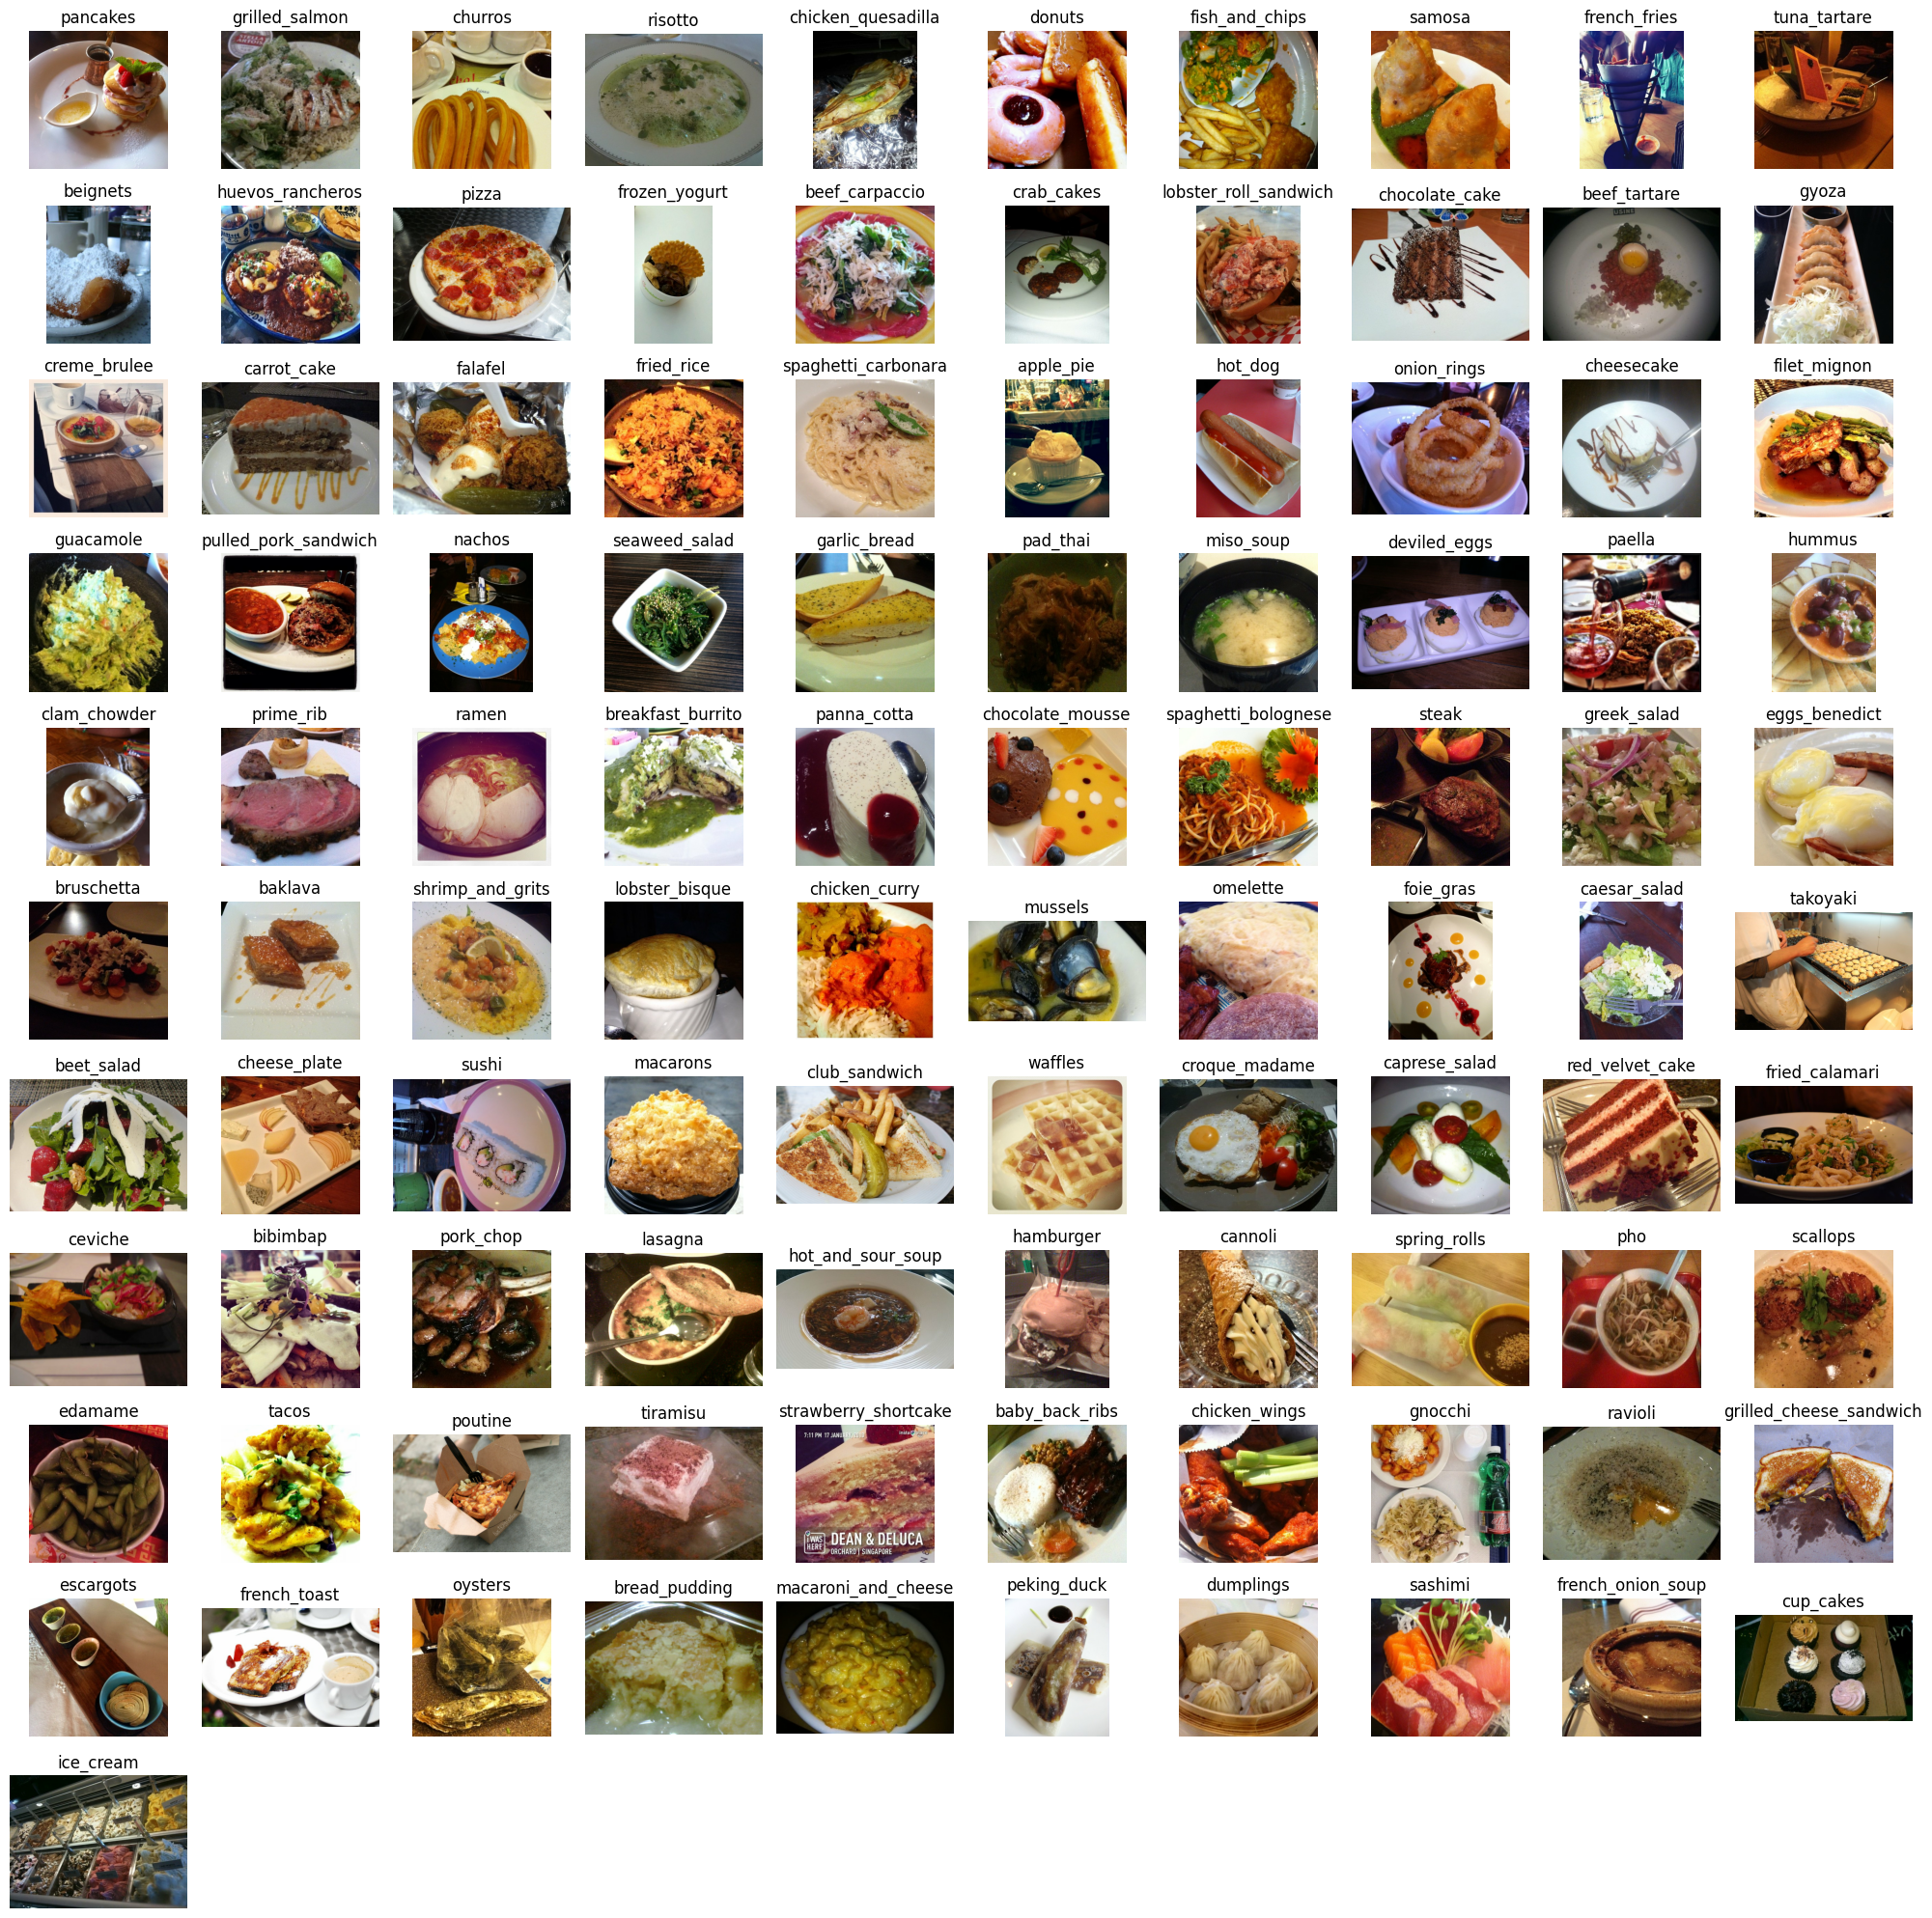

In [5]:
class_names = ds_info.features["label"].names
class_images = {}

for image, label in train_data:
    label_int = label.numpy()
    
    if label_int not in class_images:
        class_images[label_int] = image
    
    if len(class_images) == len(class_names):
        break

plt.figure(figsize=(20, 20))
for idx, (class_label, image) in enumerate(class_images.items()):
    plt.subplot(11, 10, idx + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_names[class_label])
    plt.axis("off")

plt.tight_layout()
plt.show()

In [6]:
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [8]:
unique_labels = set()

for image, label in test_data:
    unique_labels.add(label.numpy())

sorted_labels = sorted(unique_labels)
print(sorted_labels)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


The Data is Label Encoded So SparseCategoricalCrossEntropy Function Will be Used as Loss Function

In [7]:
train_data = train_data.map(map_func= preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [6]:
checkpoint_dir = "model_checkpoints"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_path = os.path.join(checkpoint_dir, "cp.weights.h5")
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=2,
                                                  restore_best_weights=True)

In [8]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
mixed_precision.global_policy()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


<Policy "mixed_float16">

In [11]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
], name="data_augmentation")

inputs = layers.Input(shape=input_shape, name="input_layer")

x = data_augmentation(inputs)

x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

print(f"Total layers in the base model: {len(base_model.layers)}")

model.summary()


Total layers in the base model: 237
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_______

In [9]:
history_feature_extraction = model.fit(train_data,
                                       epochs=10,
                                       steps_per_epoch=None,
                                       validation_data=test_data,
                                       validation_steps=None,
                                       callbacks=[model_checkpoint, early_stopping])

Epoch 1/10
2368/2368 [==============================] - 197s 79ms/step - loss: 2.1967 - accuracy: 0.4717 - val_loss: 1.3848 - val_accuracy: 0.6347
Epoch 2/10
2368/2368 [==============================] - 186s 79ms/step - loss: 1.7041 - accuracy: 0.5706 - val_loss: 1.2735 - val_accuracy: 0.6600
Epoch 3/10
2368/2368 [==============================] - 187s 79ms/step - loss: 1.5730 - accuracy: 0.5961 - val_loss: 1.2133 - val_accuracy: 0.6732
Epoch 4/10
2368/2368 [==============================] - 187s 79ms/step - loss: 1.5038 - accuracy: 0.6132 - val_loss: 1.1825 - val_accuracy: 0.6814
Epoch 5/10
2368/2368 [==============================] - 188s 79ms/step - loss: 1.4497 - accuracy: 0.6248 - val_loss: 1.1752 - val_accuracy: 0.6828
Epoch 6/10
2368/2368 [==============================] - 188s 79ms/step - loss: 1.4155 - accuracy: 0.6326 - val_loss: 1.1695 - val_accuracy: 0.6828
Epoch 7/10
2368/2368 [==============================] - 188s 79ms/step - loss: 1.3771 - accuracy: 0.6409 - val_loss: 1

In [10]:
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 41s 52ms/step - loss: 1.1467 - accuracy: 0.6895


[1.1466801166534424, 0.6895445585250854]

Precision: 0.6976
Recall: 0.6895
F1-Score: 0.6880


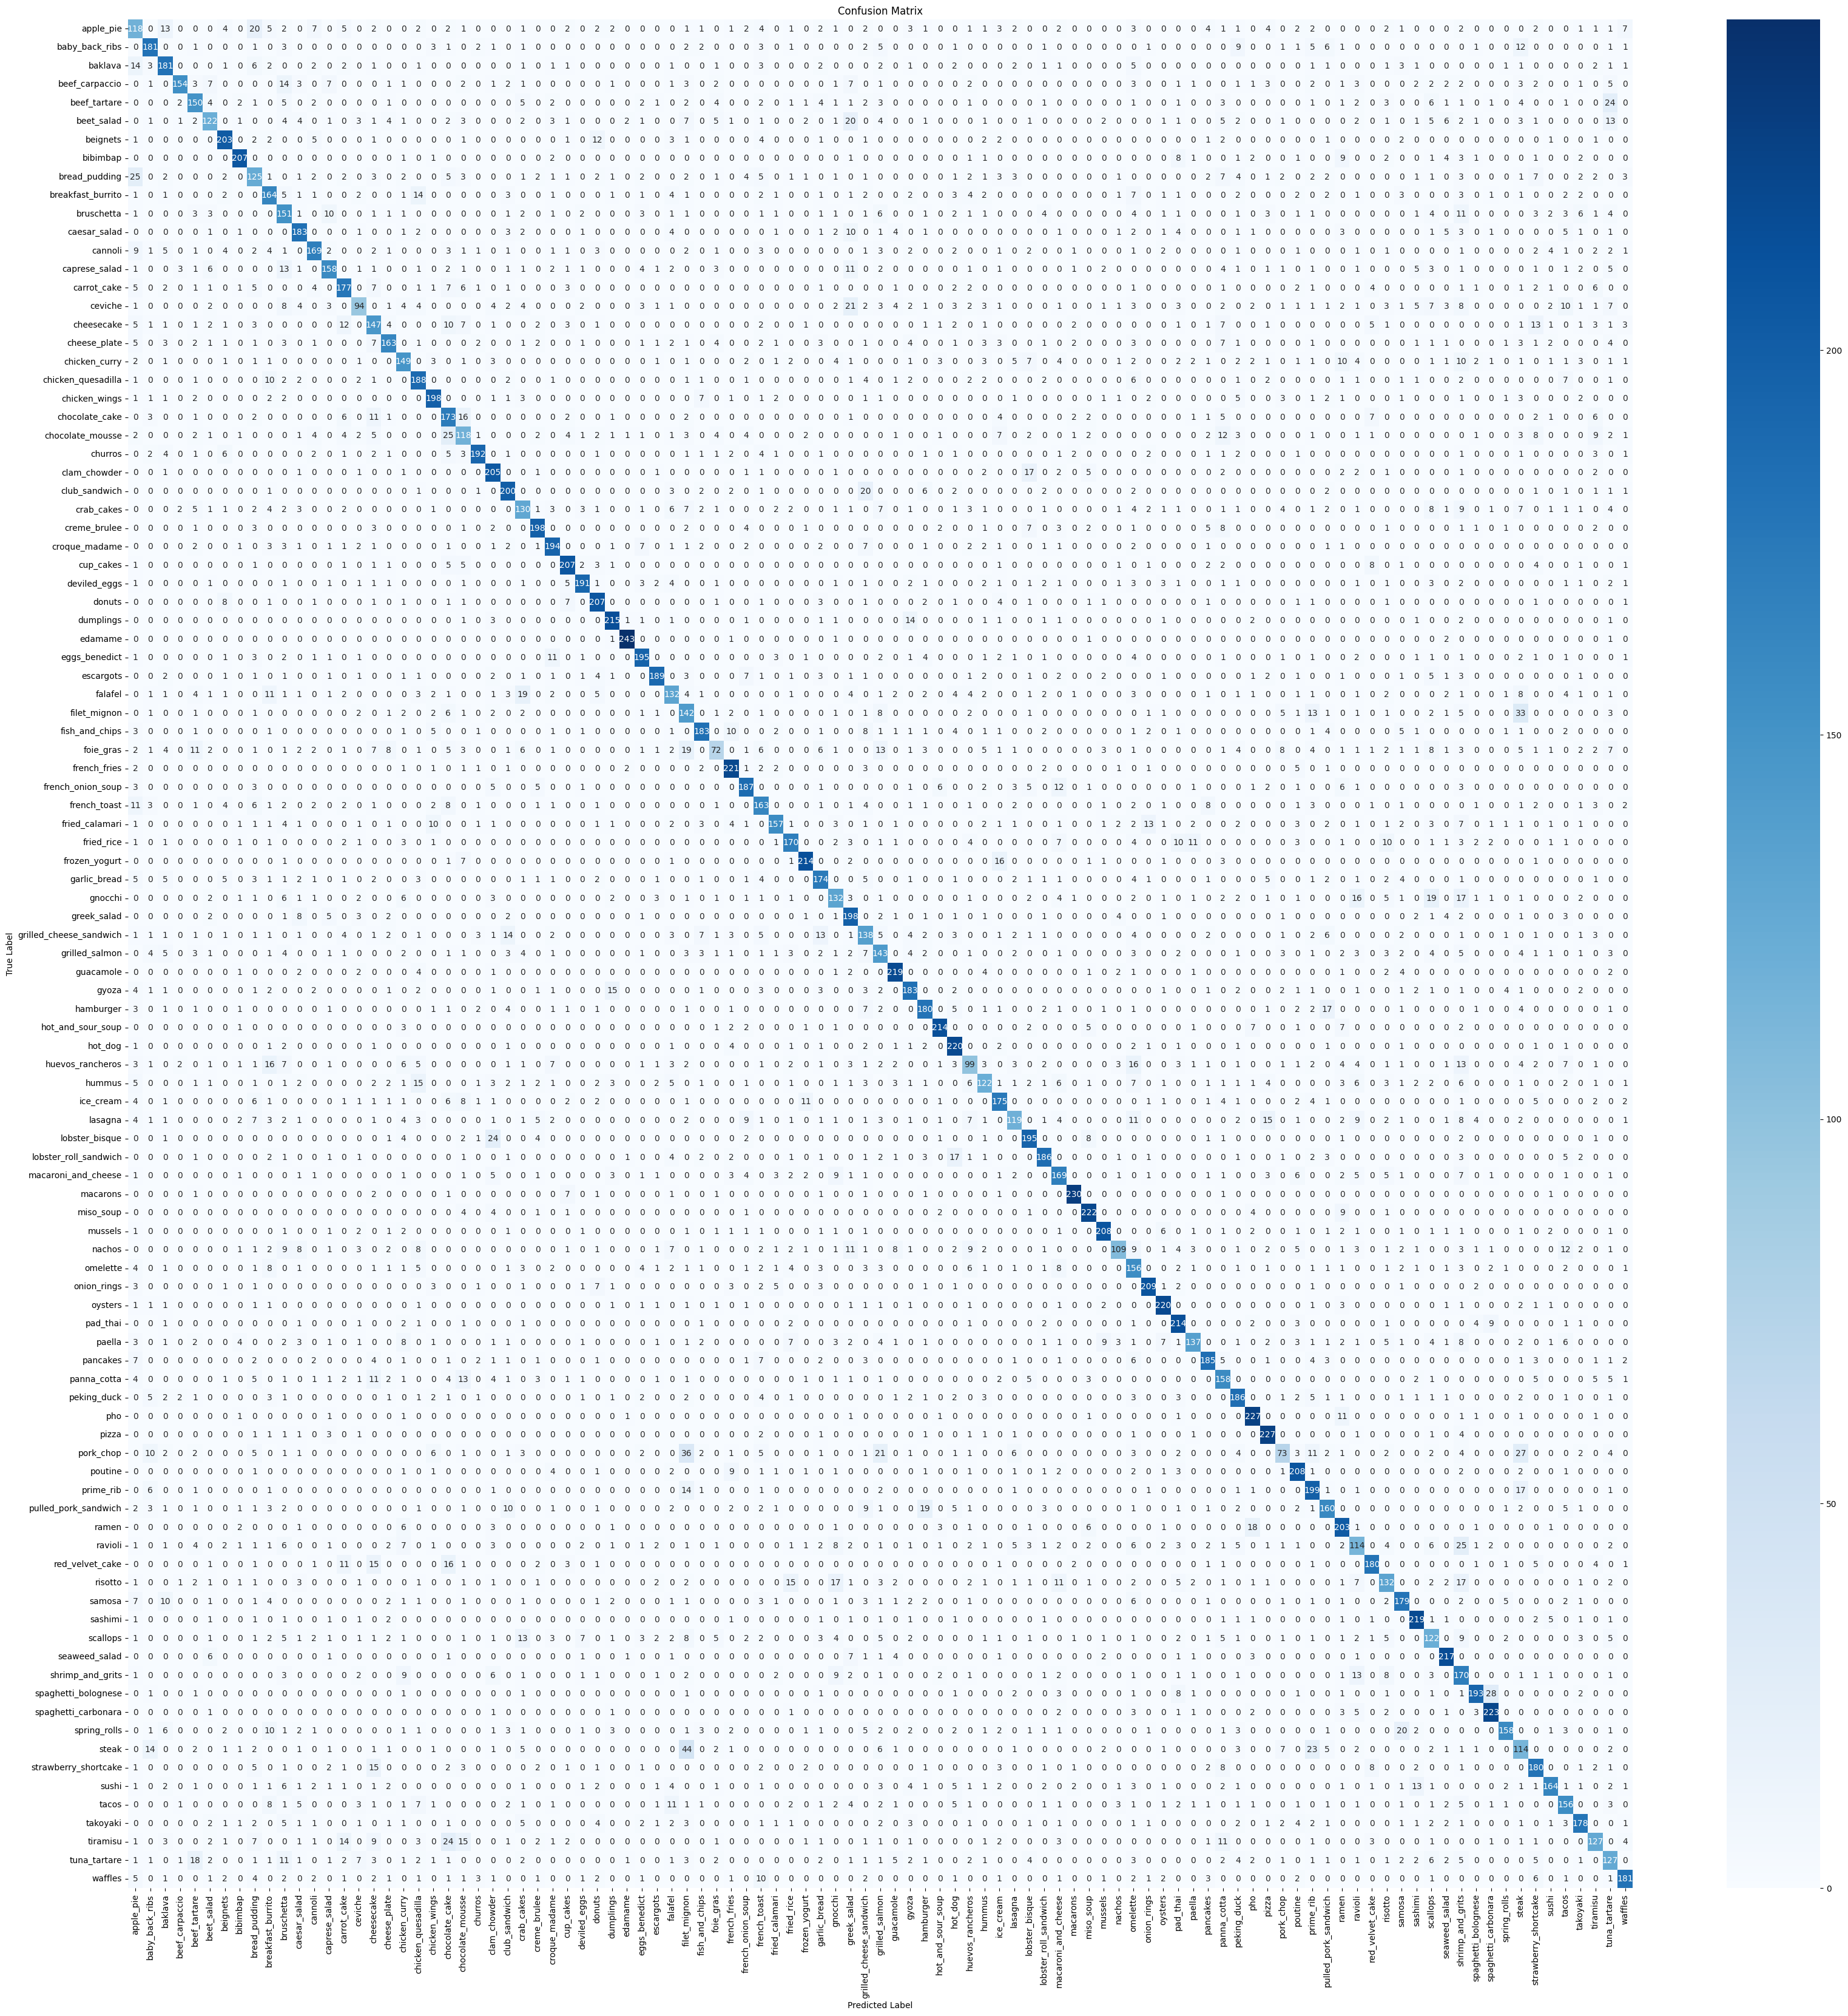

In [11]:
def calculate_metrics(model, test_data, class_names):
    y_true = []
    y_pred = []

    for images, labels in test_data:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(tf.argmax(preds, axis=1).numpy())

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-Score: {:.4f}".format(f1))    

    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    plt.figure(figsize=(40, 40))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=True, vmin=0, vmax=np.max(cm))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

calculate_metrics(model, test_data, class_names)

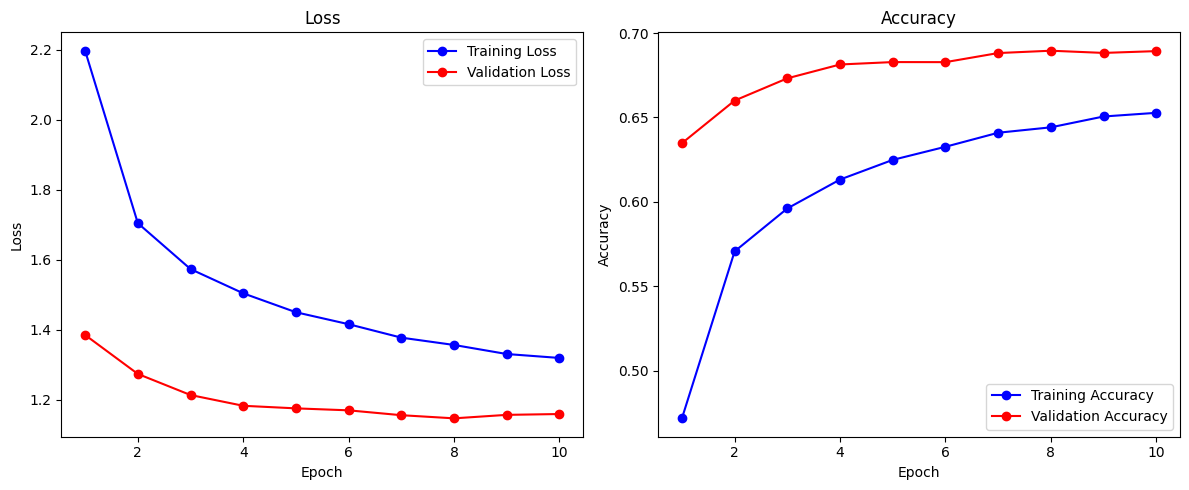

In [12]:
def plot_learning_curves(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_learning_curves(history_feature_extraction)

In [10]:
base_model.trainable = True

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=["accuracy"])

print(f"Total layers in the base model: {len(base_model.layers)}")

trainable_layers = len([layer for layer in base_model.layers if layer.trainable])
non_trainable_layers = len([layer for layer in base_model.layers if not layer.trainable])

print(f"Number of trainable layers: {trainable_layers}")
print(f"Number of non-trainable layers: {non_trainable_layers}")

model.summary()

Total layers in the base model: 237
Number of trainable layers: 137
Number of non-trainable layers: 100
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952

In [14]:
history_fine_tuning = model.fit(train_data,
                                epochs=20,
                                validation_data=test_data,
                                callbacks=[model_checkpoint, early_stopping])

Epoch 1/20
2368/2368 [==============================] - 321s 130ms/step - loss: 1.1064 - accuracy: 0.7066 - val_loss: 0.9953 - val_accuracy: 0.7280
Epoch 2/20
2368/2368 [==============================] - 310s 131ms/step - loss: 0.9993 - accuracy: 0.7339 - val_loss: 0.9598 - val_accuracy: 0.7387
Epoch 3/20
2368/2368 [==============================] - 311s 131ms/step - loss: 0.9428 - accuracy: 0.7451 - val_loss: 0.9311 - val_accuracy: 0.7458
Epoch 4/20
2368/2368 [==============================] - 311s 131ms/step - loss: 0.8993 - accuracy: 0.7592 - val_loss: 0.9190 - val_accuracy: 0.7493
Epoch 5/20
2368/2368 [==============================] - 311s 131ms/step - loss: 0.8556 - accuracy: 0.7673 - val_loss: 0.9082 - val_accuracy: 0.7557
Epoch 6/20
2368/2368 [==============================] - 311s 131ms/step - loss: 0.8217 - accuracy: 0.7774 - val_loss: 0.8943 - val_accuracy: 0.7573
Epoch 7/20
2368/2368 [==============================] - 313s 132ms/step - loss: 0.7899 - accuracy: 0.7849 - val_

In [15]:
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 41s 52ms/step - loss: 0.8856 - accuracy: 0.7609


[0.8855842351913452, 0.7608712911605835]

Precision: 0.7670
Recall: 0.7609
F1-Score: 0.7612


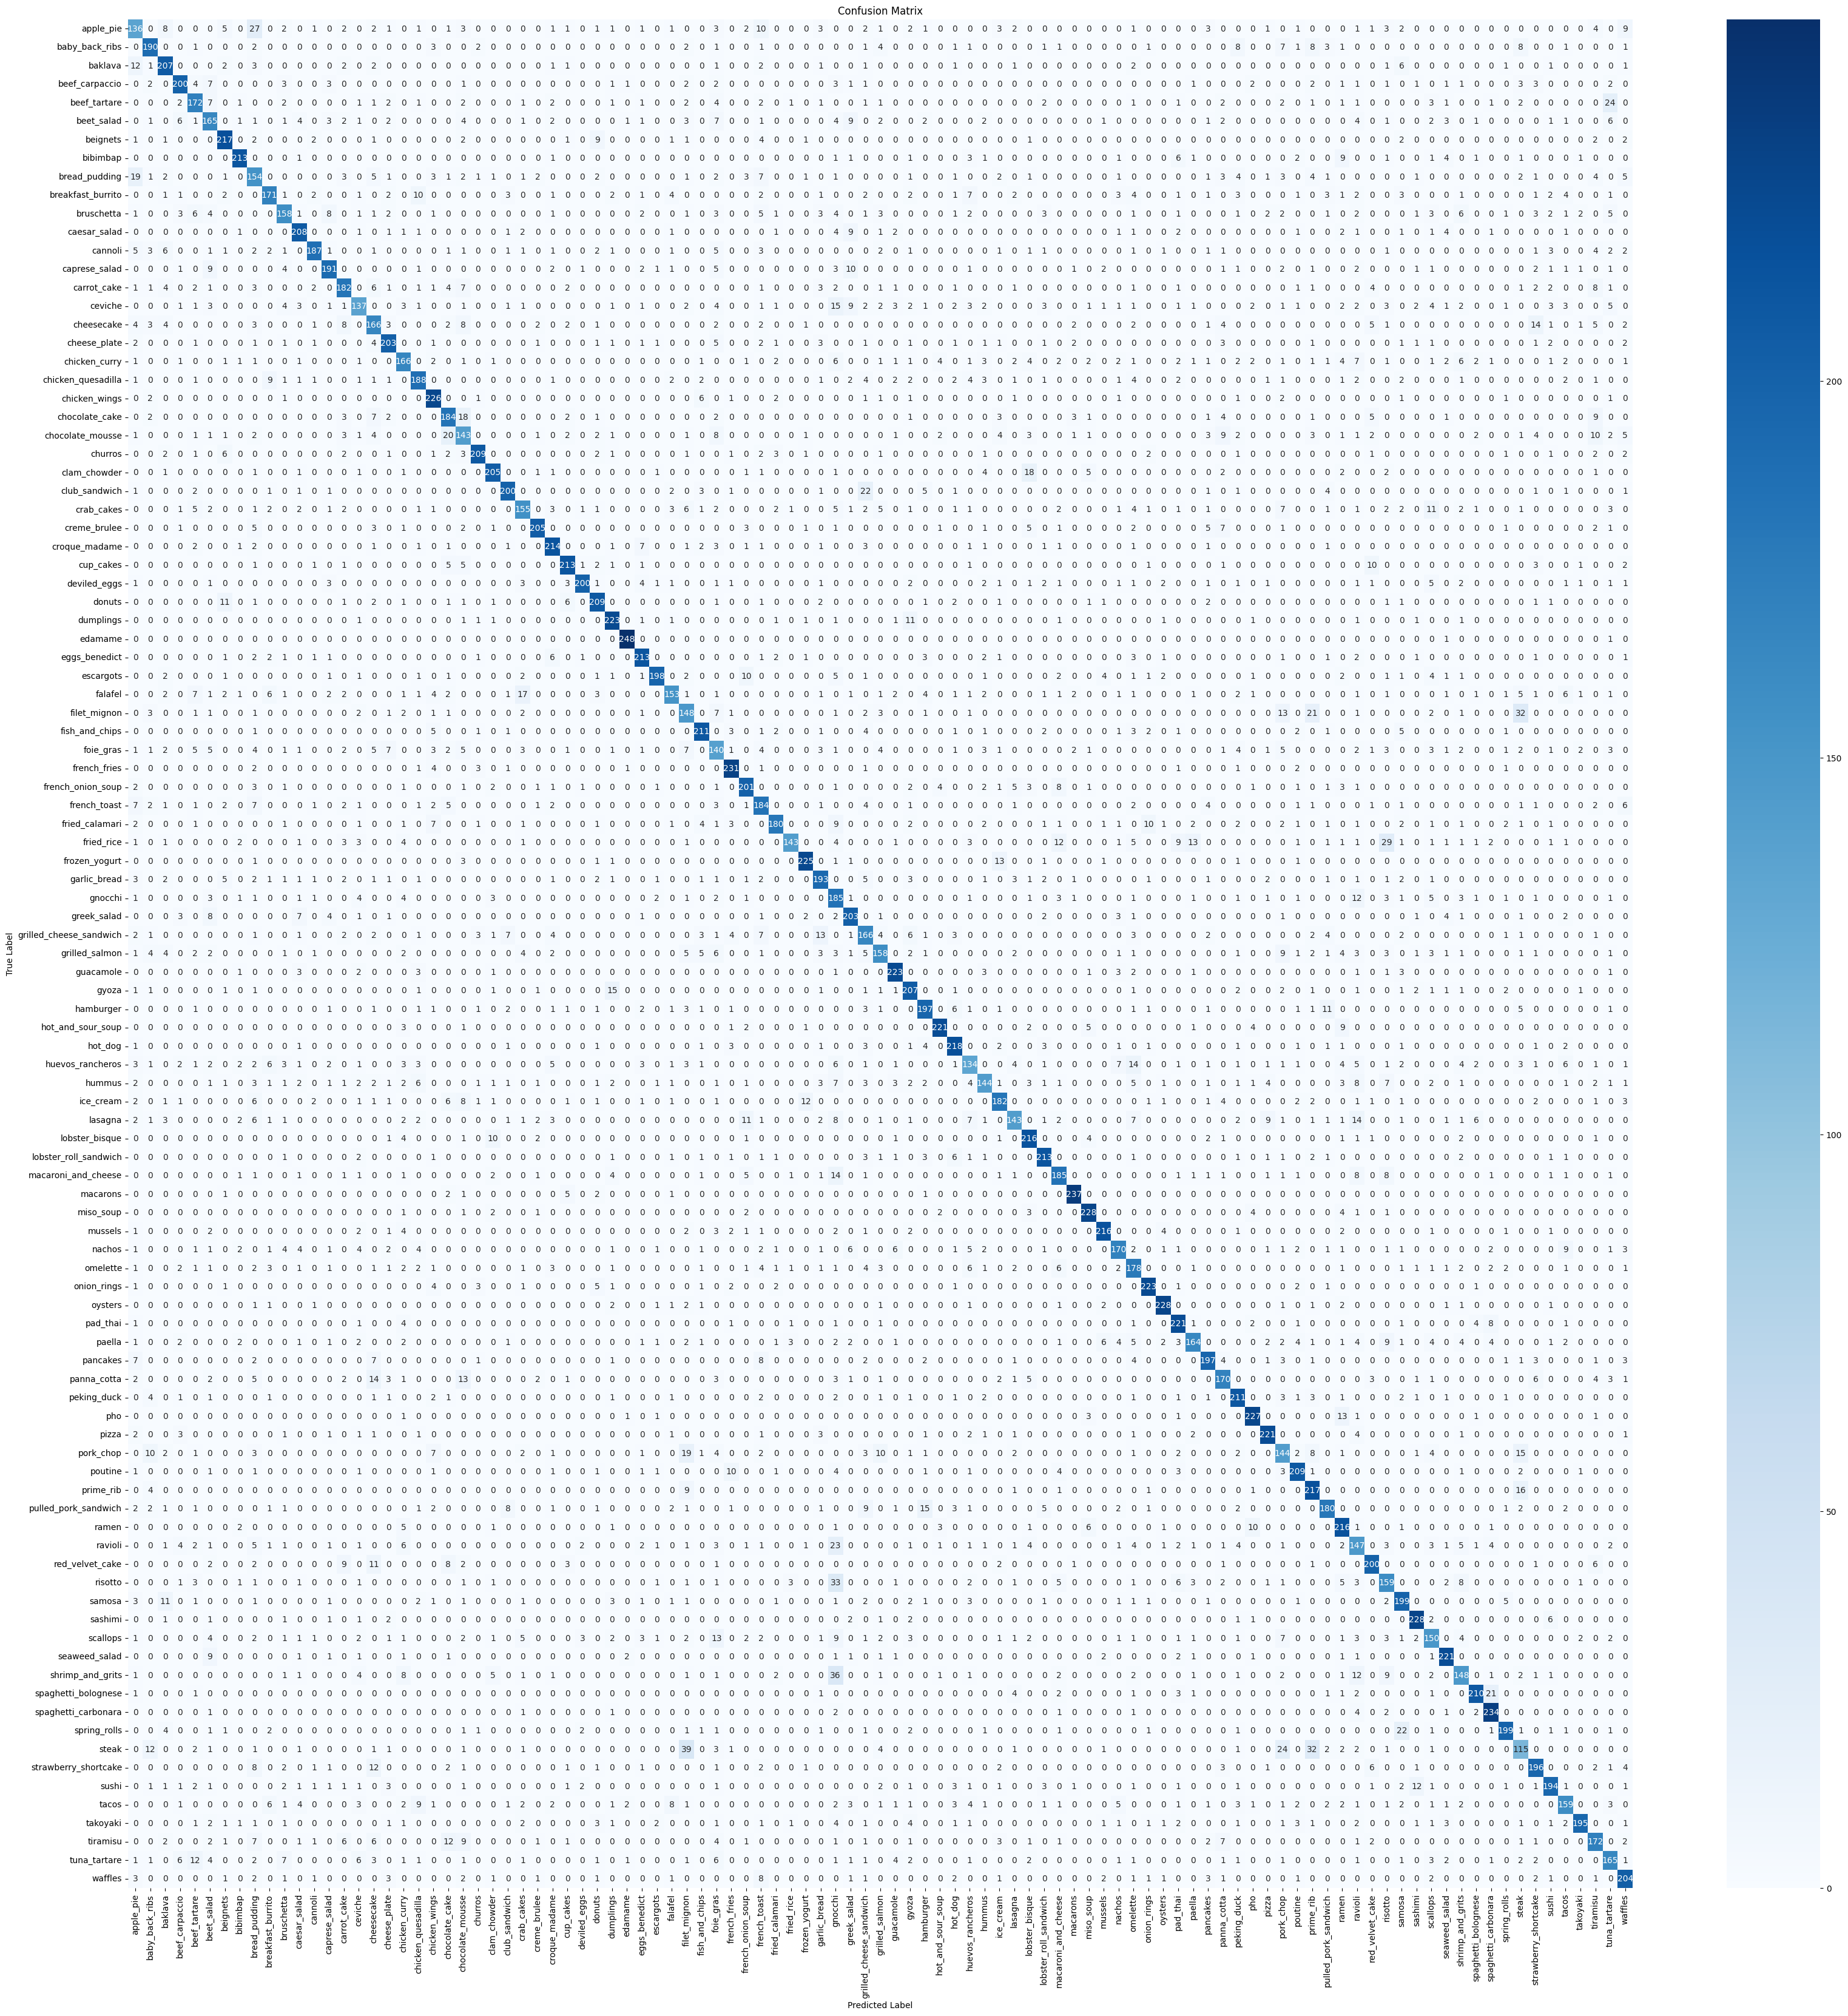

In [16]:
def calculate_metrics(model, test_data, class_names):
    y_true = []
    y_pred = []

    for images, labels in test_data:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(tf.argmax(preds, axis=1).numpy())

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-Score: {:.4f}".format(f1))    

    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    plt.figure(figsize=(40, 40))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=True, vmin=0, vmax=np.max(cm))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

calculate_metrics(model, test_data, class_names)

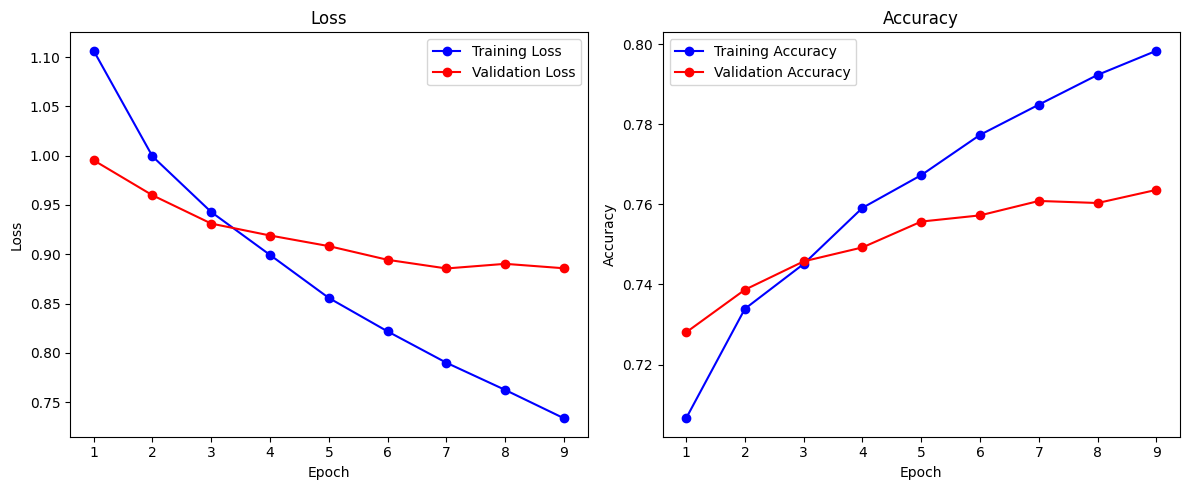

In [17]:
def plot_learning_curves(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.tight_layout()
    plt.show()


plot_learning_curves(history_fine_tuning)